In [ ]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error



In [ ]:
url = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Stock_Edwards_Lifesciences_corporation.csv'

# 판다스로 데이터를 불러오시오.
data = pd.read_csv(url)

data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [ ]:
data.drop(['Date'], axis=1, inplace=True)
# data = data.drop(['Date'], axis=1, inplace=False)
data.head()

,Open,High,Low,Close,Adj_Close,Volume
0,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [ ]:
# 판다스 데이터 프레임을 넘파이로 옮김.
data = data.values

In [ ]:
# close 컬럼의 위치를 주의해주세요.
# 너무 어렵다면,  앞전 실습의 코드를 가져다가 '수정'해보는 전략으로 진행하는 것도 좋습니다.


## 모양 확인 필수

# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
timestep= 50   # 5일씩 4주

# x의 데이터 구조를 3차원으로 만들어줘야 합니다.
# x = np.array([data[i : i + timestep,:] for i in range( len(data) - timestep ) ])
# y = np.array([data[i + timestep, -1] for i in range( len(data) - timestep ) ])

# 쉬운 버전
x = [ ]  # x를 담을 빈 공간
y = [ ]  # y를 담을 빈 공간

for i in range( len(data)-timestep ):
    x_temp = data[i:i+timestep, :]  # 21개 시점으로 끊어, 모든 컬럼
    y_temp = data[i+timestep, -3]

    x.append(x_temp)
    y.append(y_temp)

x = np.array(x)
y = np.array(y)


x_train, x_val, x_test = x[:-15], x[-15:-5], x[-5:]
y_train, y_val, y_test = y[:-15], y[-15:-5], y[-5:]

print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
print('-------------------------------')
print('[ # , timestep, feature수 ] <-- 데이터의 구조 : ')

(4342, 50, 6) (4342,)
-------------------------------
(4327, 50, 6) (4327,)
(10, 50, 6) (10,)
(5, 50, 6) (5,)
-------------------------------
[ # , timestep, feature수 ] <-- 데이터의 구조 : 


In [ ]:
x_train.shape, y_train.shape

((4327, 50, 6), (4327,))

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN
from tensorflow.keras.layers import Input, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPool1D

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.backend import clear_session

from tensorflow.keras.utils import plot_model

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Dense, Bidirectional, LSTM, GRU, Flatten
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
##################################### chatGPT #######################################
# Clear any existing Keras session
clear_session()

# Define input layer
il = Input(shape=(50, 6), name='input_layer')   

# Apply Conv1D layer with 16 filters, window size of 5, and swish activation
hl = Conv1D(filters=16,
            kernel_size=5, 
            activation='swish', 
            padding='same', 
            name='Conv_1')(il)
hl = Conv1D(filters=16, 
            kernel_size=5, 
            activation='swish', 
            padding='same',
            name='Conv_2')(hl)

# Apply MaxPool1D layer with window size of 2
hl = MaxPool1D(pool_size=2, name='Pool_1')(hl) 

# Apply Bidirectional LSTM layer with 32 hidden state nodes
hl = Bidirectional(LSTM(32, return_sequences=True), name='Bidirectional_1')(hl)

# Apply Bidirectional layer with a forward GRU and a backward LSTM, both with 32 hidden state nodes
forward_gru = GRU(32, return_sequences=True, name='forward_gru')
backward_lstm = LSTM(32, return_sequences=True, go_backwards=True, name='backward_lstm')
hl = Bidirectional(forward_gru, backward_layer=backward_lstm, name='Bidirectional_2')(hl) 

# Apply Flatten layer
hl = Flatten(name='flatten')(hl)

# Apply output layer with a Dense layer with 1 node and a ReLU activation function for regression
ol = Dense(1, activation='relu', name='positive_regression')(hl)

# Define the model with the input and output layers
# model = Model(inputs=il, outputs=ol)
model = Model(il, ol)

# 4. 컴파일
model.compile(loss=keras.losses.mae, optimizer='adam')

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 6)]           0         
                                                                 
 Conv_1 (Conv1D)             (None, 50, 16)            496       
                                                                 
 Conv_2 (Conv1D)             (None, 50, 16)            1296      
                                                                 
 Pool_1 (MaxPooling1D)       (None, 25, 16)            0         
                                                                 
 Bidirectional_1 (Bidirectio  (None, 25, 64)           12544     
 nal)                                                            
                                                                 
 Bidirectional_2 (Bidirectio  (None, 25, 64)           21824     
 nal)                                                        

In [ ]:
## 학습도 시킬 것

## 학습도 시킬 것
model.fit(x_train, y_train, epochs=30,
          verbose=1, validation_data=(x_val, y_val) )

Epoch 1/30
136/136 [==============================] - 20s 67ms/step - loss: 22.0373 - val_loss: 98.0785
Epoch 2/30
136/136 [==============================] - 8s 62ms/step - loss: 21.4651 - val_loss: 99.9418
Epoch 3/30
136/136 [==============================] - 9s 64ms/step - loss: 21.5725 - val_loss: 95.9447
Epoch 4/30
136/136 [==============================] - 8s 56ms/step - loss: 21.4508 - val_loss: 95.5907
Epoch 5/30
136/136 [==============================] - 11s 79ms/step - loss: 21.4273 - val_loss: 96.1788
Epoch 6/30
136/136 [==============================] - 10s 71ms/step - loss: 21.4188 - val_loss: 95.1087
Epoch 7/30
136/136 [==============================] - 8s 61ms/step - loss: 21.5086 - val_loss: 98.9436
Epoch 8/30
136/136 [==============================] - 9s 66ms/step - loss: 21.4282 - val_loss: 96.4280
Epoch 9/30
136/136 [==============================] - 9s 63ms/step - loss: 21.5147 - val_loss: 98.0932
Epoch 10/30
136/136 [==============================] - 8s 58ms/step - 

In [ ]:
y_pred = model.predict(x_test)

ValueError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.

# Q1. 테스트 셋에서의 RMSE를 출력하여라.
MSE(y_test, y_pred)**.5

NameError: ignored

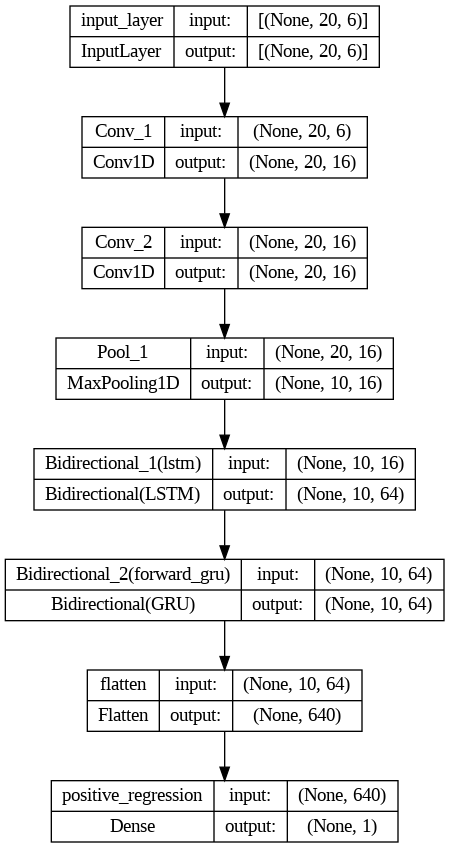

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)